## Importing and defining functions

The two functions below are responsible for getting the ring systems of a molecule in rdkit.Chem.Mol format and returning the ring fragments in canonical SMILES notation. 

This is achieved by using the `get_ring_systems()` function that returns atom indexes of each ring/ring system within a given molecule. Then, coupled with `get_ring_adjacent()` we can use this info to retrieve neighbouring atoms and return atom indexes of each henceforth caleld ring fragment `(ring + immediate adjacent atoms)`. 

Finally we use these two functions together to generate a list of ring fragments from parent structures.

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.rdmolfiles import MolFragmentToSmiles
from rdkit.Chem.PandasTools import AddMoleculeColumnToFrame
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import HTML
IPythonConsole.molSize = (600,300)
IPythonConsole.drawOptions.addAtomIndices = True

# To show rdkit.Chem.Mol objects in > 1 code chunk per notebook
def show_df(df):
    return HTML(df.to_html(notebook=True))

In [2]:
def get_ring_systems(mol, includeSpiro=False):
    """
    Retrieve atom indices grouped into ring systems within a given molecule.
    
    Args:
        mol (rdkit.Chem.Mol): RDKit molecule object representing the molecular structure.
        includeSpiro (bool, optional): If True, include spiro-connected atoms in the ring systems. 
            Defaults to False.

    Returns:
        list of set: A list of sets, where each set contains the indices of atoms belonging to a ring system.
    """
    ri = mol.GetRingInfo()
    systems = []

    # Scaping
    if len(ri.AtomRings()) == 0:
        return [0] # Return a carbon
    
    for ring in ri.AtomRings():
        ringAts = set(ring)
        nSystems = []
        for system in systems:
            nInCommon = len(ringAts.intersection(system))

            if nInCommon and (includeSpiro or nInCommon>1):
                ringAts = ringAts.union(system)
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems
    return systems

def get_ring_adjacent(mol):
    """
    Retrieve atom indices within ring systems along with their adjacent atoms. This functions have the get_ring_systems() as a dependency;

    Args:
        mol (rdkit.Chem.Mol): RDKit molecule object representing the molecular structure.

    Returns:
        list of set: A list of sets, where each set contains the indices of atoms in a ring system 
        along with their adjacent atoms.
    """
    ring_systems = get_ring_systems(mol, includeSpiro=False)

    rings = []
    for ring in ring_systems:
        ring_with_adjacent = set(ring)
        for ring_atom in ring:
            neighbors = set(mol.GetAtomWithIdx(ring_atom).GetNeighbors())
            
            for neighbor_atom in neighbors:
                if (neighbor_atom.GetIdx() not in ring) and (neighbor_atom.GetIsAromatic()):
                    neighbor_atom.SetIsAromatic(False)
                    ring_with_adjacent.add(neighbor_atom.GetIdx())
                else:
                    ring_with_adjacent.add(neighbor_atom.GetIdx())
        rings.append(ring_with_adjacent)

    return rings

To give an example, we show the behavior of the functions using Gefitinib, a medication used for breast cancer. This code is based on the pre-printed article [Expanding Bioactive Fragment Space with the Generated Database GDB-13s](https://chemrxiv.org/engage/chemrxiv/article-details/64b6848cb605c6803bed39a2).

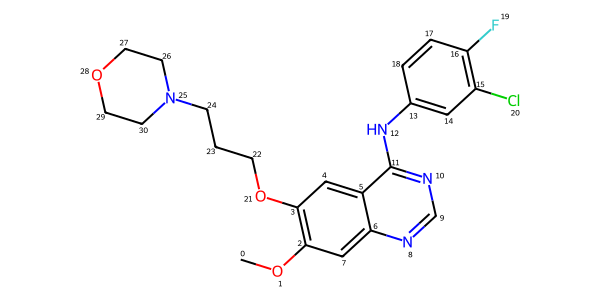

In [3]:
gefitinib = Chem.MolFromSmiles('COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OCCCN4CCOCC4')
gefitinib

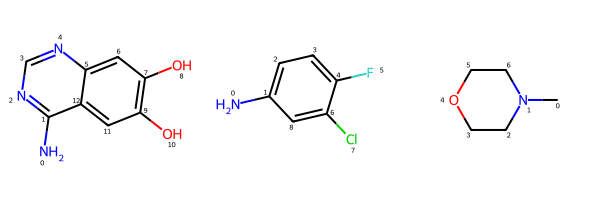

In [4]:
rings = get_ring_adjacent(gefitinib)
mols = []

for ring in rings:
    mol = Chem.MolFromSmiles(MolFragmentToSmiles(gefitinib, atomsToUse=ring))
    mols.append(mol)
Draw.MolsToGridImage(mols)

## Algorithm: Generating Ring Fragment Data

### 1. Input Data Preparation:
Gather a collection of chemical structures in SMILES notation. This collection will be referred to as `A`.

### 2. Initialization:
- Initialize an empty list to store generated fragments, along with their parent SMILES and associated identifiers. This list will be referred to as `B`.
- Initialize an empty list to capture structures without any rings. This list is referred to as `C`.

### 3. Ring Fragment Generation:
Loop through each SMILES representation in `A`.

### 4. Process Each SMILES:
- Convert the current SMILES into a MOL object for analysis.
- Check if the molecule has at least one ring.

**Case 1: Molecule Has Rings**
- For each ring present in the molecule, extract the atoms that compose the ring and their adjacent atoms.
- Store the information of the parent structure, the ring fragment, and the original identifier in the list `B` for future reference.

**Case 2: Molecule Has No Rings**
- If the molecule doesn't contain any rings, identify it as a structure without rings.
- Append the structure's information to the list `C`.

In [6]:
# Data
fda_drugs_df = pd.read_csv('../../data/fda_approved_datasets/pre_cleaned_datasets/pre_cleaned_unique.csv')
list_of_smiles = fda_drugs_df['clean_smiles'].to_list()
# chembl_id
# To search through the SMILES
chembl_ids = fda_drugs_df[['clean_smiles', 'chembl_id']]

# Empty list
parents_and_fragments = []
no_rings = []

for smiles in list_of_smiles:
    mol = Chem.MolFromSmiles(smiles)
    if get_ring_systems(mol) == [0]:
        no_rings.append(smiles)
    else:
        rings = get_ring_adjacent(mol)
        for ring in rings:
            ring_fragment = Chem.MolToSmiles(Chem.MolFromSmiles(Chem.MolFragmentToSmiles(mol, atomsToUse=ring)))
            parent_smiles = smiles

            chembl_id = chembl_ids[chembl_ids['clean_smiles'] == parent_smiles].chembl_id.iloc[0]
            parents_and_fragments.append(
                {
                'parent_smiles': parent_smiles, 
                'ring_fragment': ring_fragment,
                'chembl_id': chembl_id
                }
            )

# Transforming it into pd.DataFrame (wide-format)
ring_fragments_df = pd.DataFrame.from_dict(parents_and_fragments)

,parent_smiles,ring_fragment,chembl_id,parent_mol,fragment_mol
0,Cc1cn[nH]c1,Cc1cn[nH]c1,CHEMBL1308,,
1,C1CNCCN1,C1CNCCN1,CHEMBL1412,,
2,Nc1ccncc1,Nc1ccncc1,CHEMBL284348,,
3,N[C@@H]1CONC1=O,N[C@@H]1CONC1=O,CHEMBL771,,
4,Nc1ccncc1N,Nc1ccncc1N,CHEMBL354077,,
...,...,...,...,...,...
3764,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,Cc1c(O)cc2c(c1O)-c1cc(ccc1O)[C@H]1NC(=O)[C@@H]...,CHEMBL507870,,
3765,CC(C)CC(NC(=O)C(C)NC(=O)CNC(=O)C(NC=O)C(C)C)C(...,Cc1c[nH]c2ccccc12,CHEMBL1201469,,
3766,CC(C)CC(NC(=O)C(C)NC(=O)CNC(=O)C(NC=O)C(C)C)C(...,Cc1c[nH]c2ccccc12,CHEMBL1201469,,
3767,CC(C)CC(NC(=O)C(C)NC(=O)CNC(=O)C(NC=O)C(C)C)C(...,Cc1c[nH]c2ccccc12,CHEMBL1201469,,

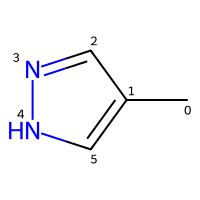
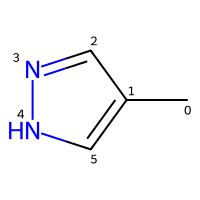
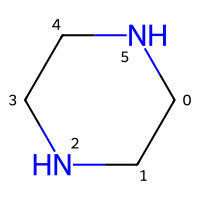
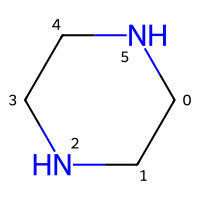
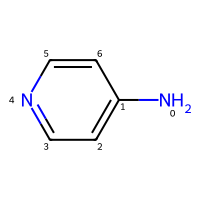
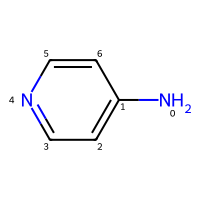
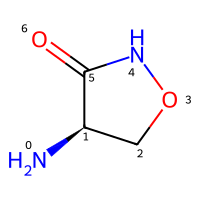
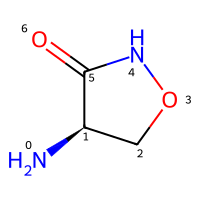
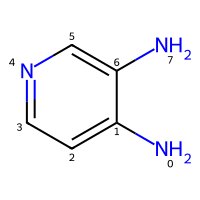
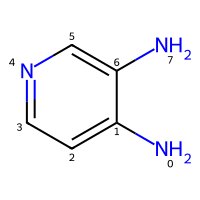
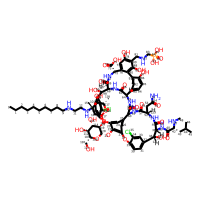
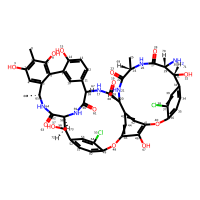
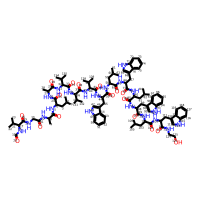
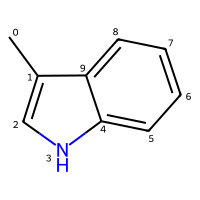
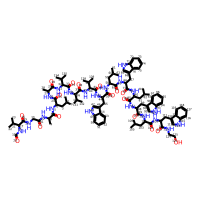
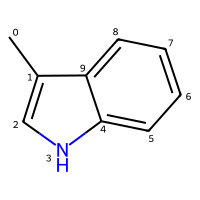
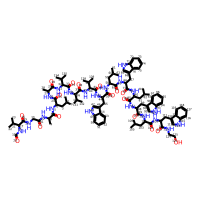
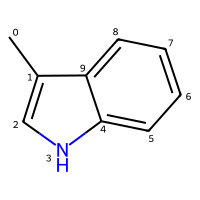
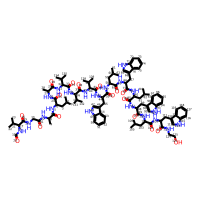
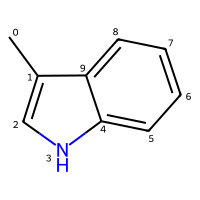

In [7]:
# Visualize both the parent and fragment mol
AddMoleculeColumnToFrame(smilesCol='parent_smiles', molCol='parent_mol', frame=ring_fragments_df)
AddMoleculeColumnToFrame(smilesCol='ring_fragment', molCol='fragment_mol', frame=ring_fragments_df)
(ring_fragments_df)

The final question is to wheather consider repeated fragements WITHIN the same structure. For example, a semi-synthetic polypeptide chemical structure can have multiple 'tryptophan ring fragments'. Should I consider a fragment for each structure only once?

### Potential Challenges and Considerations:
1. **Ring Detection:**
   - Ensure the accuracy of the `get_ring_systems()` function for detecting rings in molecules.

2. **Adjacency Information:**
   - Confirm the accuracy of retrieving adjacent atoms for generating meaningful ring fragments.

3. **Data Integrity:**
   - Verify the quality and integrity of input SMILES data to prevent unexpected behavior.

4. **Parent-Child Relationship:**
   - Establish accurate linkage between parent structures and generated ring fragments.

5. **Handling Complex Rings:**
   - Address the handling of complex ring systems or multiple rings in molecules.

6. **Efficiency:**
   - Optimize your code for efficiency, especially for larger datasets.

7. **Memory Management:**
   - Manage memory effectively when working with a significant number of structures.

8. **Retrieval of Information:**
   - Ensure organized storage in `B` for easy retrieval of information.

By addressing these challenges and following the steps outlined above, you can generate ring fragments from your input SMILES data effectively.